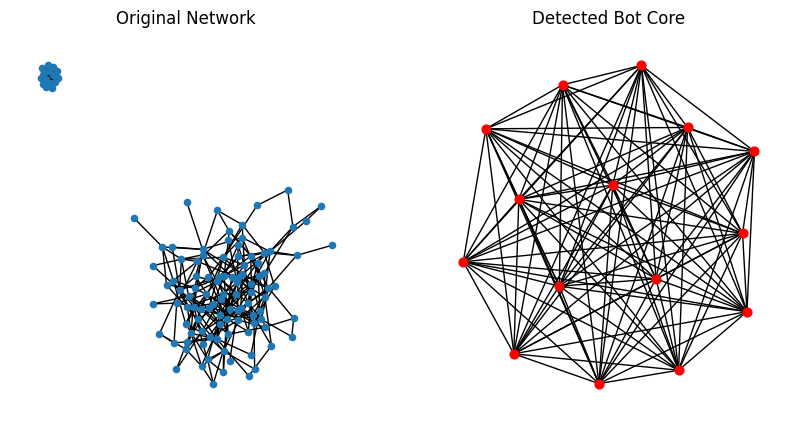

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

# Generating crowd of humans and bots
# Create 100 random humans and 15 bots 
num_humans = 100
num_bots = 15
human_network = nx.erdos_renyi_graph(num_humans, 0.05) # Connected humans graph (each human has a 5% chance of connecting to another)
bot_network = nx.complete_graph(num_bots)            # Bot connections (all bots are connected)
bot_network = nx.relabel_nodes(bot_network, {i: i + num_humans for i in range(num_bots)}) #Assigning nodes to each ID, shifting over so bot IDs don't overlap with human IDs
human_network = nx.compose(human_network, bot_network) # Merging humans and bots together

# LOGIC: The K-Core Pruning Function
def get_k_core(graph, k):

    adj = {node: set(neighbors) for node, neighbors in graph.adjacency()} # Convert to a dictionary adjacency list for speed O(1) lookup time

    while True:
        # Find nodes that have fewer than K neighbors
        to_remove = [node for node, neighbors in adj.items() if len(neighbors) < k]
        
        if not to_remove:
            break 
            
        for node in to_remove:
            # Remove this node from its neighbors' adjacency lists
            for neighbor in adj[node]:
                adj[neighbor].remove(node)
            # Remove the node itself
            del adj[node]
            
    return nx.Graph(adj) # Convert back to NetworkX for visualization

# RUN
bot_core = get_k_core(human_network, k=10)

# VISUALIZE
plt.figure(figsize=(10,5))
plt.subplot(121); nx.draw(human_network, node_size=20); plt.title("Original Network")
plt.subplot(122); nx.draw(bot_core, node_size=40, node_color='red'); plt.title("Detected Bot Core")
plt.show()

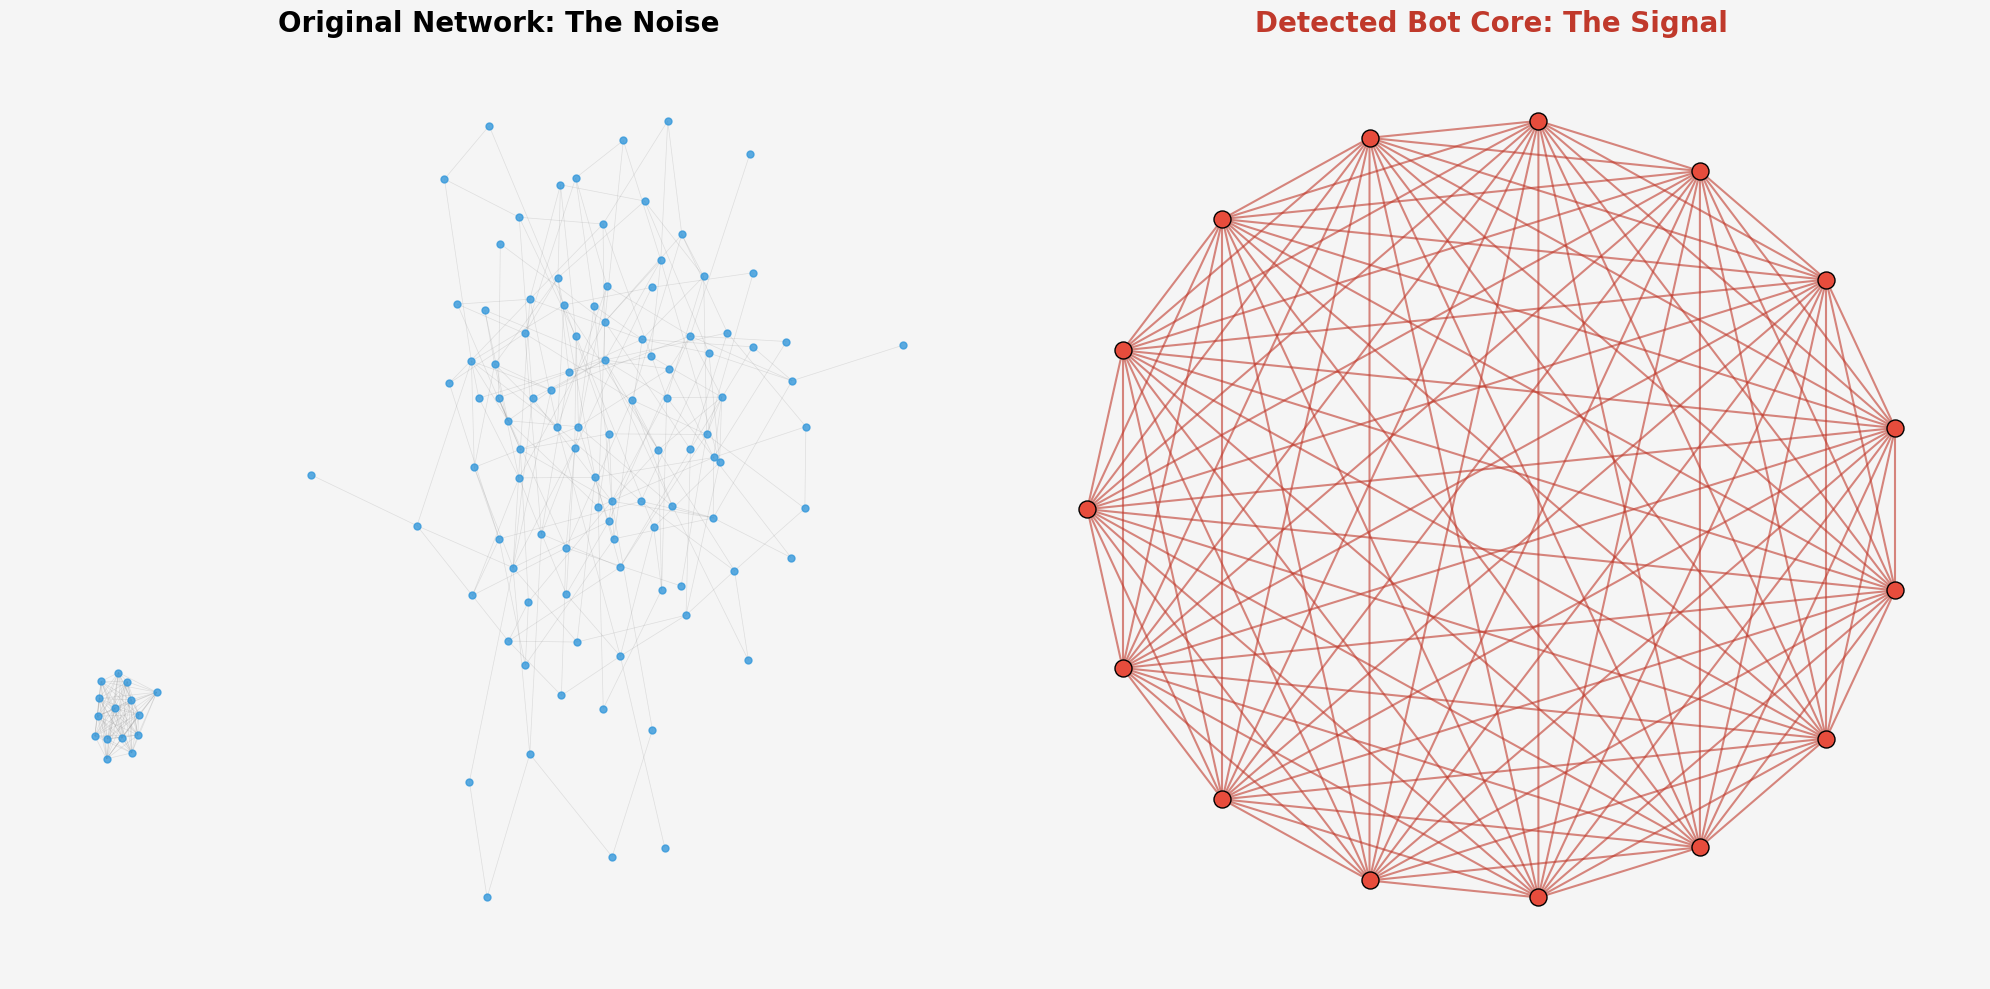

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_clean_comparison(original_G, core_G):
    # Create a figure with a dark, professional background
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), facecolor='#F5F5F5')
    
    # Use 'Spring Layout' to position nodes further apart to see the "structure"
    pos_orig = nx.spring_layout(original_G, k=0.15, iterations=50, seed=42)
    pos_core = nx.shell_layout(core_G) # Shell layout looks much cleaner for cliques
    
    # Draw Original Network
    nx.draw_networkx_nodes(original_G, pos_orig, node_size=25, 
                           node_color='#3498db', alpha=0.8, ax=ax1)
    nx.draw_networkx_edges(original_G, pos_orig, width=0.5, 
                           edge_color='grey', alpha=0.2, ax=ax1) # Low alpha = cleaner
    ax1.set_title("Original Network: The Noise", fontsize=20, fontweight='bold')
    ax1.axis('off')

    # Draw Bot Clique
    nx.draw_networkx_nodes(core_G, pos_core, node_size=150, 
                           node_color='#e74c3c', edgecolors='black', ax=ax2)
    nx.draw_networkx_edges(core_G, pos_core, width=1.5, 
                           edge_color='#c0392b', alpha=0.6, ax=ax2)
    ax2.set_title("Detected Bot Core: The Signal", fontsize=20, fontweight='bold', color='#c0392b')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

# Run visualization
draw_clean_comparison(human_network, bot_core)

In [17]:
import networkx as nx

file_path = "twitter_combined.txt"  # File path for functional Twitter dataset

def load_twitter_data(file_path):
    print("Loading Twitter data from:", file_path) # Loading Standford SNAP Dataset information by Jure Leskovec
    print("Opening file")
    # Using nx.read_edgelist to optimize space
    # Twitter file uses spaces between IDs
    twitter_graph = nx.read_edgelist(file_path, create_using=nx.Graph(), nodetype=int)
    return twitter_graph


In [18]:
twitter_network  = load_twitter_data(file_path)

print("Successfully loaded", twitter_network.number_of_nodes(), "users")
print("Successfully loaded", twitter_network.number_of_edges(), "connections")

Loading Twitter data from: twitter_combined.txt
Opening file
Successfully loaded 81306 users
Successfully loaded 1342310 connections
